In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yaml
def load_config(config_file):
    with open(config_file, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

In [4]:
from collections import namedtuple
config = load_config('settings_detector_xwav_default.yaml')
# detParams = namedtuple('detParams', config.keys())(*config.values())
# detParams = DetParams(**config)
detParams = type('DetParams',(object,),config)()

In [5]:
from wavio import *
from functions import *
from detection import *

In [6]:
dt_buildDirs(detParams)

In [7]:
fullFileNames = fn_findXWAVs(detParams.baseDir, 'x.wav')
fullLabels = fn_getFileset(detParams.metaDir, fullFileNames)
fullFileNames, fullLabels

(['/Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_150728_020000.x.wav'],
 ['/Users/Jim/Documents/Project/WhaleClassification/output/Arctic_C2_10_150728_020000_metadata/Arctic_C2_10_150728_020000.txt'])

In [8]:
currentRecFile = fullFileNames[0]
outFileName = fullLabels[0]
hdr = io_readXWavHeader(currentRecFile)
vars(hdr)

{'end': <wavio.AnonymousClass at 0x11797cf90>,
 'fType': 'xwav',
 'fs': 200000,
 'nBits': 16,
 'nch': 1,
 'raw': <wavio.AnonymousClass at 0x10aab4a10>,
 'samp': <wavio.AnonymousClass at 0x10aab4d50>,
 'start': <wavio.AnonymousClass at 0x11797cf50>,
 'xgain': 1,
 'xhd': <wavio.AnonymousClass at 0x11797cfd0>}

In [9]:
startsSec, stopsSec = dt_chooseSegmentsRaw(hdr)
startsSec, stopsSec

(array([   0.        ,   75.00000001,  150.00000002,  225.00000003,
         300.00000003,  375.00000004,  450.00000005,  525.00000006,
         900.00000003,  975.00000003, 1050.00000004, 1125.00000005,
        1200.00000006, 1274.99999999, 1350.        , 1425.00000001,
        1800.00000005, 1875.00000006, 1949.99999999, 2025.        ,
        2100.00000001, 2175.00000002, 2250.00000003, 2325.00000003,
        2700.        , 2775.00000001, 2850.00000002, 2925.00000003,
        3000.00000003, 3075.00000004]),
 array([  74.99999506,  149.99999499,  224.999995  ,  299.99999501,
         374.99999501,  449.99999502,  524.99999503,  599.99999504,
         974.99999501, 1049.99999501, 1124.99999502, 1199.99999503,
        1274.99999504, 1349.99999505, 1424.99999506, 1499.99999499,
        1874.99999503, 1949.99999504, 2024.99999505, 2099.99999506,
        2174.99999499, 2249.999995  , 2324.99999501, 2399.99999501,
        2774.99999506, 2849.99999499, 2924.999995  , 2999.99999501,
        

In [10]:
previousFs, _ = fn_buildFilters(detParams, hdr.fs)
# detParams.previousFs = previousFs
params = fn_interp_tf(detParams)
if 'countThresh' not in vars(detParams) or detParams.countThresh == 0:
    detParams.countThresh = (10**((detParams.dBppThreshold - np.median(detParams.xfrOffset))/20))/2

--ends in *dt_batch* #57 ---

## Starts from here

In [29]:
def dt_postproc(outFileName, clickTimes, params, hdr, encounterTimes):

    # Step through vector of click times, looking forward and back to throw out
    # solo clicks, and pairs of clicks, if they are too far away from a cluster
    # of clicks with >2 members.
    # outputs a vector of pruned times, and a vector flagging which members
    # should be removed from other variables.
    # Writes pruned times to .pTg file.

    delFlag = np.ones(len(clickTimes), dtype=int) # t/f vector of click deletion flags. 
    # starts as all 1 to keep all clicks. Elements switch to zero as clicks are
    # flagged for deletion.

    ### Get rid of lone clicks ###
    if params.rmLonerClicks:
       
        # Step through deleting clicks that are too far from their preceeding
        # and following click    
        if len(clickTimes) > 2:
            for itr1 in range(len(clickTimes)):
                if itr1 == 0:
                    if clickTimes[itr1+1,1]-clickTimes[itr1,0]>params.maxNeighbor:
                        delFlag[itr1]= 0
                elif itr1 == len(clickTimes)-1:
                    prevIdxs = np.where[delFlag[0:itr1]==1][0]
                    if not len(prevIdxs):
                        delFlag[itr1] = 0
                    prevClick = max(prevIdxs)
                    if clickTimes[itr1,1] - clickTimes[prevClick,0]>params.maxNeighbor:
                        delFlag[itr1] = 0
                else:
                    prevIdxs = np.where[delFlag[0:itr1]==1][0]
                    if not len(prevIdxs):
                        if clickTimes[itr1+1,1] - clickTimes[itr1,0]>params.maxNeighbor:
                            delFlag[itr1] = 0
                    prevClick = max(prevIdxs)
                    if clickTimes[itr1,1] - clickTimes[prevClick,0]>params.maxNeighbor\
                        and clickTimes[itr1+1,1]-clickTimes[itr1,0]>params.maxNeighbor:
                        delFlag[itr1] = 0
        else:
            delFlag = np.zeros(len(clickTimes))
    # [TODO]: Get rid of pulsed calls

    # get rid of duplicate times:
    if len(clickTimes) > 1:
        dtimes = np.diff(clickTimes[:,0])
        closeStarts = np.where(dtimes<0.00002)[0]
        delFlag[closeStarts+1] = 0

    if params.rmEchos:
        # Added 150318 KPM - remove echoes from captive recordings.  Lock out
        # period N seconds from first click detection of set. 
        # [TODO] Need check correctness
        iCT = 0
        while iCT <= len(clickTimes):
            thisClickTime = clickTimes[:,iCT]
            tDiff = clickTimes[:,0] - thisClickTime
            echoes = (np.where(tDiff <= params.lockOut) and np.where(tDiff > 0))[0]
            delFlag[echoes] = 0 # flag close clicks in time for deletion.
            if not len(echoes): # advance to next detection
                iCT = iCT +1
            else: # or if some were flagged, advance to next true detection
                iCT = echoes[-1]+1
    
    # [TODO] Translate
    #### Remove times outside desired times, for guided detector case
    #     if params.guidedDetector:
    #         if not len(encounterTimes):
    #             # Convert all clickTimes to "real" datenums, re baby jesus
    #             sec2dnum = 60*60*24 # conversion factor to get from seconds to matlab datenum
    #             clickDnum = (clickTimes/sec2dnum) + hdr.start.dnum + datenum([2000,0,0])
    #             for itr2 = 1:size(clickDnum,1)
    #                 thisStart = clickDnum(itr2,1)
    #                 thisEnd = clickDnum(itr2,2)
    #                 afterStarts = find(encounterTimes(:,1)> thisStart)
    #                 firstAfterStart = min(afterStarts) # this is the start of the guided period it should be in
    #                 beforeEnd = find(encounterTimes(:,2)> thisEnd)
    #                 firstBeforeEnd = min(beforeEnd)
    #                 if firstAfterStart ~= firstBeforeEnd
    #                     # Then this click does not fall within an encounter, chuck it
    #                     delFlag(itr2) = 0
    #                 end
    #             end
    #         else
    #             fprintf('No times to prune.\n')
    #         end
    #     end

    clickTimesPruned = clickTimes[delFlag==1] # apply deletions

    np.savetxt(outFileName, clickTimesPruned, fmt='%.5f')
    return delFlag

In [30]:
from __future__ import division
import numpy as np
from scipy.signal import filtfilt
import time

cParams = dt_init_cParams(detParams) # set up storage for HR output.
sIdx = 0
# Open audio file
start = time.time()

with open(currentRecFile, 'r') as fh:
    buffSamples = int(detParams.LRbuffer*hdr.fs)
    # Loop through search area, running short term detectors
    detParams.clickSampleLims = np.int64(np.ceil((hdr.fs/10**6)*\
                                         np.array([detParams.delphClickDurLims[0]*.75,\
                                         detParams.delphClickDurLims[1]*1.25])))
    for k in range(len(startsSec)):
        
        startK = startsSec[k]
        stopK = stopsSec[k]

        # [TODO] Read in data segment for WAV format
        dat = io_readRaw(fh, hdr, k, detParams.channel)
        
        # bandpass
        if detParams.filterSignal:
            padlen = 3*(max(len(detParams.fB),len(detParams.fA))-1)
            filtData = filtfilt(detParams.fB, detParams.fA, dat, padtype='odd', padlen=padlen)
        else:
            filtData = dat
        
        energy = filtData ** 2
        
        ### Run LR detection to identify candidates
        ts = time.time()
        detectionsSample,detectionsSec =  dt_LR(energy,hdr,buffSamples,startK,stopK,detParams)
        
        # [2/9]
        # [FUTURE] PARALLEL in detectionsSample
        ts = time.time()
        for iD in range(len(detectionsSample)):
            # [FUTURE] HOW TO EXTRACT SUBARRAY FROM NP ARRAY WITH DIFFERENT LENGTH
            filtSegment = filtData[detectionsSample[iD][0]:detectionsSample[iD][1]+1]
            clicks, noise = dt_HR(detParams, hdr, filtSegment)
            if len(clicks):
                # if we're in here, it's because we detected one or more possible
                # clicks in the kth segment of data
                # Make sure our click candidates aren't clipped
                validClicks = dt_pruneClipping(clicks, params, hdr, filtSegment)

                # Look at power spectrum of clicks, and remove those that don't
                # meet peak frequency and bandwidth requirements
                clicks = clicks[validClicks==1]
                # Compute click parameters to decide if the detection should be kept
                clickDets,f = dt_parameters(noise, filtSegment, params, clicks, hdr)
                if len(clickDets.clickInd):
                    # populate cParams
                    cParams, sIdx = dt_populate_cParams(clicks, params, clickDets,
                                                        detectionsSec[iD][0], hdr, sIdx, cParams)
        
print 'done with %s\n'%currentRecFile
end = time.time()
print round(end-start,2), ' s'

cParams = dt_prune_cParams(cParams,sIdx)

# Run post processing to remove rogue loner clicks, prior to writing
# the remaining output files.
clickTimes = cParams.clickTimes[cParams.clickTimes[:,0].argsort()]

encounterTimes = []

keepFlag = dt_postproc(outFileName,clickTimes,params,hdr,encounterTimes)
keepIdx = np.where(keepFlag==1)[0]

baseFileName = os.path.splitext(outFileName)[0]
fn_saveDets2pkl(baseFileName+'.pkl',cParams,f,hdr,params)

done with /Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_150728_020000.x.wav

15.87  s


## Verbose

In [21]:
from __future__ import division
import numpy as np
from scipy.signal import filtfilt
import time

timecosts = list()
start = time.time()

cParams = dt_init_cParams(detParams) # set up storage for HR output.
sIdx = 0
# Open audio file
with open(currentRecFile, 'r') as fh:
    buffSamples = int(detParams.LRbuffer*hdr.fs)
    # Loop through search area, running short term detectors
    detParams.clickSampleLims = np.int64(np.ceil((hdr.fs/10**6)*\
                                         np.array([detParams.delphClickDurLims[0]*.75,\
                                         detParams.delphClickDurLims[1]*1.25])))
    loop = start
    for k in range(len(startsSec)):
        timecost = list()
        loop = time.time()
        
        startK = startsSec[k]
        stopK = stopsSec[k]

        # [TODO] Read in data segment for WAV format
        ts = time.time()
        dat = io_readRaw(fh, hdr, k, detParams.channel)
        print 'reading data costs', round(time.time() - ts,2)
        timecost.append(round(time.time() - ts,2))
        
        ts = time.time()
        # bandpass
        if detParams.filterSignal:
            padlen = 3*(max(len(detParams.fB),len(detParams.fA))-1)
            filtData = filtfilt(detParams.fB, detParams.fA, dat, padtype='odd', padlen=padlen)
        else:
            filtData = dat
        print 'filtData costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        energy = filtData ** 2
        
        ### Run LR detection to identify candidates
        ts = time.time()
        detectionsSample,detectionsSec =  dt_LR(energy,hdr,buffSamples,startK,stopK,detParams)
        print 'lr costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        # [2/9]
        # [FUTURE] PARALLEL in detectionsSample
        ts = time.time()
        for iD in range(len(detectionsSample)):
            # [FUTURE] HOW TO EXTRACT SUBARRAY FROM NP ARRAY WITH DIFFERENT LENGTH
            filtSegment = filtData[detectionsSample[iD][0]:detectionsSample[iD][1]+1]
            clicks, noise = dt_HR(detParams, hdr, filtSegment)
            if len(clicks):
                # if we're in here, it's because we detected one or more possible
                # clicks in the kth segment of data
                # Make sure our click candidates aren't clipped
                validClicks = dt_pruneClipping(clicks, params, hdr, filtSegment)

                # Look at power spectrum of clicks, and remove those that don't
                # meet peak frequency and bandwidth requirements
                clicks = clicks[validClicks==1]
                # Compute click parameters to decide if the detection should be kept
                clickDets,f = dt_parameters(noise, filtSegment, params, clicks, hdr)
                if len(clickDets.clickInd):
                    # populate cParams
                    cParams, sIdx = dt_populate_cParams(clicks, params, clickDets,
                                                        detectionsSec[iD][0], hdr, sIdx, cParams)
        print 'hl costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        print round(time.time() - loop, 2)
        timecost.append(round(time.time() - loop,2))
        
        timecosts.append(timecost)
        
print 'done with %s\n'%currentRecFile
end = time.time()
print round(end-start,2), ' s'

cParams = dt_prune_cParams(cParams,sIdx)

# Run post processing to remove rogue loner clicks, prior to writing
# the remaining output files.
clickTimes = cParams.clickTimes[cParams.clickTimes[:,0].argsort()]

# keepFlag = dt_postproc(outFileName,clickTimes,p,hdr,encounterTimes)
# keepIdx = np.where[keepFlag==1]

baseFileName = os.path.splitext(outFileName)[0]
fn_saveDets2pkl(baseFileName+'.pkl',cParams,f,hdr,params)

reading data costs 0.09
filtData costs 0.44
lr costs 0.04
hl costs 0.26
0.89
reading data costs 0.05
filtData costs 0.38
lr costs 0.04
hl costs 0.09
0.6
reading data costs 0.05
filtData costs 0.29
lr costs 0.03
hl costs 0.07
0.46
reading data costs 0.05
filtData costs 0.3
lr costs 0.02
hl costs 0.05
0.47
reading data costs 0.05
filtData costs 0.31
lr costs 0.02
hl costs 0.05
0.46
reading data costs 0.05
filtData costs 0.29
lr costs 0.02
hl costs 0.06
0.46
reading data costs 0.05
filtData costs 0.29
lr costs 0.02
hl costs 0.04
0.44
reading data costs 0.05
filtData costs 0.3
lr costs 0.03
hl costs 0.08
0.5
reading data costs 0.05
filtData costs 0.37
lr costs 0.02
hl costs 0.06
0.53
reading data costs 0.08
filtData costs 0.35
lr costs 0.01
hl costs 0.04
0.52
reading data costs 0.05
filtData costs 0.35
lr costs 0.04
hl costs 0.1
0.59
reading data costs 0.06
filtData costs 0.38
lr costs 0.03
hl costs 0.11
0.63
reading data costs 0.07
filtData costs 0.38
lr costs 0.02
hl costs 0.06
0.56
read

Text(0.5,0,'samples')

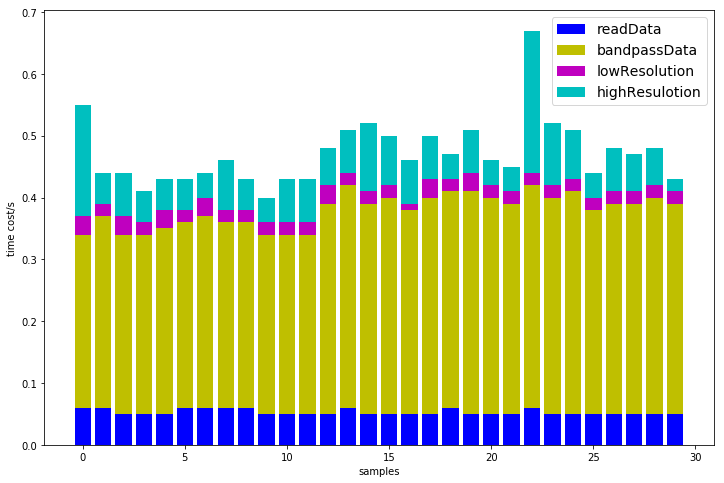

In [57]:
import matplotlib.pyplot as plt
timecosts = np.array(timecosts)
timecosts.shape
plt.figure(figsize=(12, 8))
legends = ['readData', 'bandpassData', 'lowResolution', 'highResulotion', 'total']
X = np.arange(timecosts.shape[0])
plt.bar(X,timecosts[:,0], label=legends[0], color='blue')
plt.bar(X,timecosts[:,1], bottom=timecosts[:,0],label=legends[1], color='y')
plt.bar(X,timecosts[:,2], bottom=timecosts[:,0]+timecosts[:,1],label=legends[2], color='m')
plt.bar(X,timecosts[:,3], bottom=timecosts[:,0]+timecosts[:,1]+timecosts[:,2],label=legends[3], color='c')
# for i in range(timecosts.shape[1]-1):
#     if i > 0:
#         bottom = [timecosts[:,i-1]
#         plt.bar(X,timecosts[:,i], bottom=timecosts[:,i-1], label=legends[i])
#     else:
#         plt.bar(X,timecosts[:,i], label=legends[i])
# i = 4
# plt.plot(timecosts[:,i], label=legends[i], '--')
plt.legend(prop={'size': 14})
plt.ylabel('time cost/s')
plt.xlabel('samples')